In [1]:
from qiskit import *
from qiskit.circuit.library import SXdgGate
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import time

In [6]:
def convert_to_binary(number):
    '''convert_to_binary(9) -> 
        array([1, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)'''
    number = np.array([[number]])
    return np.flip( 
                     np.unpackbits(
                        number.astype(np.uint8),
                        axis=1),
                     axis=1).reshape(-1)

def quantum_input(number, qreg):
    '''It gets number,
    converting into binary representation in a quantum circuit.'''
    circuit.reset(qreg)
    bin_array = convert_to_binary(number)
    for i in range(len(bin_array)):
        if bin_array[i] == 1:
            circuit.x(qreg[i])

csxdg_gate = SXdgGate().control()            

$$\Large{Arithmetic \ Units}$$ 

RHS (Reverse Half Subtractor)
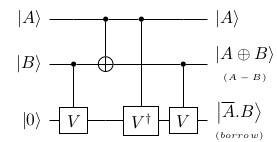

In [7]:
def half_subtractor(A, B, C):
    circuit.csx(B, C)
    circuit.cnot(A, B)
    circuit.append(csxdg_gate, [A, C])
    circuit.csx(B, C)

RFS (Reverse Full Subtractor)
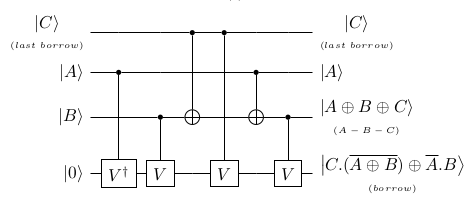

In [9]:
def full_subtractor(C, A, B, zero):
    '''Reverse Full Subtractor (RFS)
        C -> C
        A -> A
        B -> AxorBxorC
        zero -> borrow'''
    circuit.append(csxdg_gate, [A, zero])
    circuit.csx(B, zero)
    circuit.cnot(C, B)
    circuit.csx(C, zero)
    circuit.cnot(A, B)
    circuit.csx(B, zero)

Parallel Subtractor
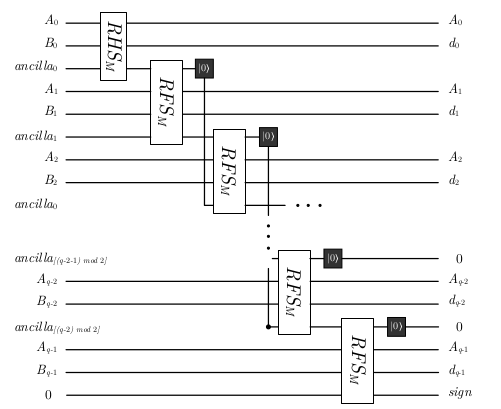

In [10]:
def parallel_subtractor(X, Y, anc, sign):
    '''Parallel Subtractor (PS)
    with 2 ancilla qubits
    # T(k) = 5*T(k-1)
    #lasted  104.1153152  seconds for k=8
    2k-1 ccx, 2k-1 cnot
    X -> X
    Y -> X-Y
    X: [0, 3, 6, ...]
    Y: [1, 4, 7, ...]
    sign: the final borrow'''
def parallel_subtractor(X, Y, anc, sign):
    
    half_subtractor(X[0], Y[0], anc[0])

    for i in range(1, len(X)):
        if i == len(X)-1:
            full_subtractor(anc[(i-1)%2],
                            X[i],
                            Y[i],
                            sign)
            circuit.reset(anc[(i-1)%2])
        else:
            full_subtractor(anc[(i-1)%2],
                            X[i],
                            Y[i],
                            anc[i%2])
            circuit.reset(anc[(i-1)%2])

    circuit.barrier()

MCNOT
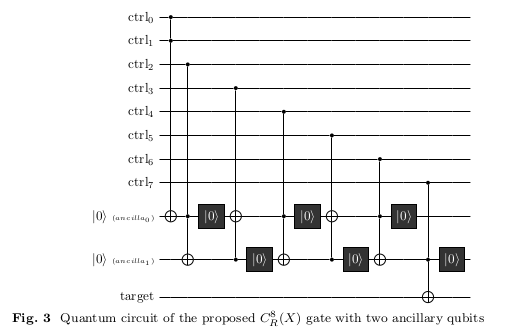

In [3]:
def mcnot(q_controls, q_target, q_ancilla, count_ccx=False):
    '''Multi Controlled Not Gate, with two ancillary qubits
    number of q_ancilla= 2
    with len(q_controls)-1 CCNOT gates. (k-1)
    '''
    if len(q_controls) == 2:
        circuit.ccx(q_controls[0], q_controls[1], q_target)
        
    else:
        circuit.ccx(q_controls[0], q_controls[1], q_ancilla[0])

        for i in range(2, len(q_controls)-1):
            circuit.ccx(q_controls[i], q_ancilla[i%2], q_ancilla[(i-1)%2])
            circuit.reset(q_ancilla[i%2])

        circuit.ccx(q_controls[len(q_controls)-1],
                    q_ancilla[(len(q_controls)-1)%2], 
                    q_target)
        circuit.reset(q_ancilla[(len(q_controls)-1)%2]);
                

2's Complement
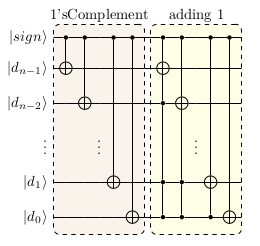

In [3]:
def twos_complement(S, anc):
    ''' 2's complement (CO in the reference)
    if the input is negative, it converts it to positive'''
    n = len(S)-1  # eq. len(S)=9 (with sign qbit)
    for i in range(n-1, -1, -1):
        circuit.cnot(S[n], S[i])
    circuit.barrier()

    for i in range(n-1, 0, -1):  # eq. 7 to 1
        q_controls = S[:i]     # [0 to 6], [0 to 5], ..., [0]
        q_controls.append(S[n])
        mcnot(q_controls=q_controls, q_target=S[i], q_ancilla=anc)
    circuit.barrier()

    circuit.cnot(S[n], S[0])
    circuit.barrier()

Absolute Distance
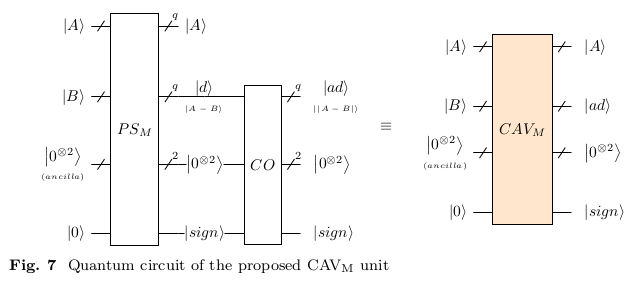

In [3]:
def absolute_distance(X, Y, anc, sign):
    '''Calculate the absolute value (CAV in the paper)
    Y -> abs(X-Y)
     with 2 ancillary qubits
    '''
    parallel_subtractor(X=X, Y=Y, anc=anc, sign=sign)
    circuit.barrier()
    twos_complement(S=Y[:]+[sign], anc=anc)

Compare Threshold
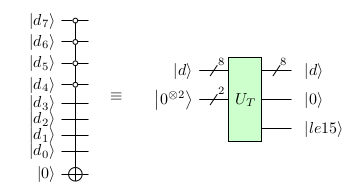

In [3]:
def compare_threshold(distance, ancilla):
    '''Compare with 15: if >15 output=0, if <=15 output=1. U_T in the paper
    return target_ancilla_idx
    '''
    distance_length = len(distance)
    distance_length_per2 = distance_length//2
    for i in range(distance_length_per2, distance_length):  # qubits 4 to 7
        circuit.x(distance[i])
        
    target_ancilla_idx = (distance_length-distance_length_per2)%2
    
    mcnot(q_controls=distance[distance_length_per2:distance_length],
          q_ancilla=ancilla,
          q_target=ancilla[target_ancilla_idx])
    
    for i in range(distance_length_per2, distance_length):
        circuit.x(distance[i])
    
    return target_ancilla_idx

# NEQR with PPRM

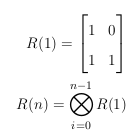

In [11]:
def R(k):  
    '''RM_Transform_Matrix'''
    if k==1:
        return np.array([[1, 0],
                         [1, 1]])
    return np.kron(R(k-1), np.array([[1, 0],
                                     [1, 1]]))

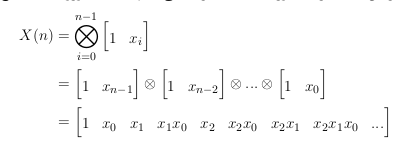
f(x) : minterms
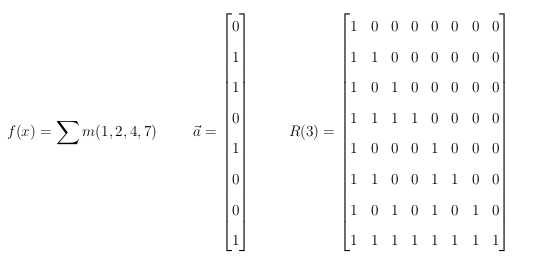
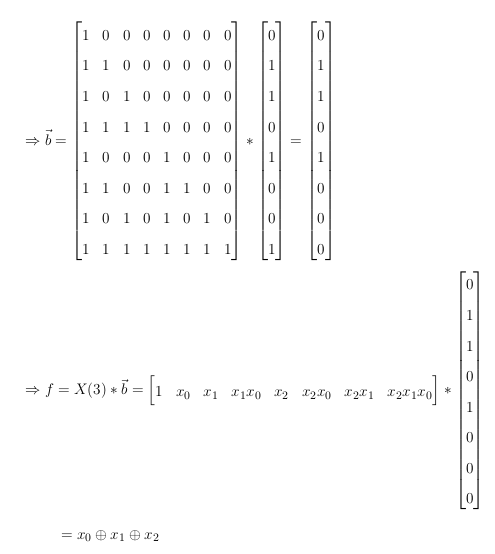

In [12]:
def rm_concat(in1, in2):
    if in1==1:
        return in2
    if in2==1:
        return in1
    return list(np.concatenate((in2, in1)))
def rm_kron(list2, list1):
    output = list1
    for i in range(len(list1)):
        output.append(rm_concat(list2[1], list1[i]))
    return output

def positve_fixed_RM(k):
    '''positve_fixed_RM(3) ->
        [1, [0], [1], [0, 1], [2], [0, 2], [1, 2], [0, 1, 2]]'''
    if k==1:
        return ([1, [0]])
    if k==2:
        return rm_kron([1, [1]], [1, [0]])
    return rm_kron([1, [k-1]], positve_fixed_RM(k-1))


In [4]:
def count_ccx(rm_dict):
    cnot_sum = 0 
    ccx_sum = 0 
    xgate_sum = 0
    for value, key in zip(rm_dict.values(), rm_dict.keys()):
        
        for exor in value:
            if exor == 1:
                xgate_sum = xgate_sum + 1
                continue
                
            if len(exor)==1:
                cnot_sum = cnot_sum + 1
            elif len(exor)==2:
                ccx_sum = ccx_sum + 1
            elif len(exor)>2:
                ccx_sum = ccx_sum + len(exor) - 1 

    return cnot_sum, ccx_sum, xgate_sum
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

### Optimized NEQR

In [4]:
def NEQR(coordinate, color, ancilla, image_binary):
    global xgate_count
    global cnot_count
    k = len(coordinate) 
    
    #------------------ dot xor ------------------ #
    b = np.dot(R(k), image_binary).transpose()
    for i in range(b.shape[0]):
        for j in range(b.shape[1]):
            b[i][j] = b[i][j]%2
    #--------------------------------------------- #        
    positve_fixed_RM_list = positve_fixed_RM(k)
    #---------- dictionary of 4 or 8 PPRM for NEQR_Block or NEQR------------ #  
    rm_dict={}
    for i in range(b.shape[0]):
        rm_list=[]
        exor_list = np.argwhere(b[i]==1).reshape(-1)
        for idx in exor_list:
            rm_list.append(positve_fixed_RM_list[idx])
        rm_dict[i] = rm_list
        
'''
{  
 0: [1, [0]]                 0: 1 xor x0
 1: []                       1: nothing
 2: [1, [0, 1]]              2: 1 xor x0x1
 3: [1, [0], [0, 1]]         3: 1 xor x0 xor x0x1
 4: [[0], [1]]               4: x0 xor x1
 5: [1, [1]]                 5: 1 xor x1
 6: [[0]]                    6: x0
 7: [1, [0], [1], [0, 1]]    7: 1 xor x0 xor x1 xor x0x1
 }
 '''
    #--------------------------------------------- # 
#     cnot_sum, ccx_sum, xgate_sum = count_ccx(rm_dict)
#     print('cnot_sum=', cnot_sum, '\tccx_sum=', ccx_sum, '\txgate_sum=', xgate_sum)
    
    for bit in range(b.shape[0]):
        for xor_term in rm_dict[bit]:
            if xor_term == 1:
                circuit.x(color[bit]); xgate_count = xgate_count + 1
                continue
            if len(xor_term)==1:
                circuit.cnot(control_qubit=coordinate[xor_term],
                             target_qubit=color[bit])
                cnot_count = cnot_count + 1
            else:
                mcnot(q_controls=coordinate[xor_term],
                      q_target=color[bit], 
                      q_ancilla=ancilla, count_ccx=True)

$$\Large{Smooth-Edge Detection Functions}$$ 

MLPS
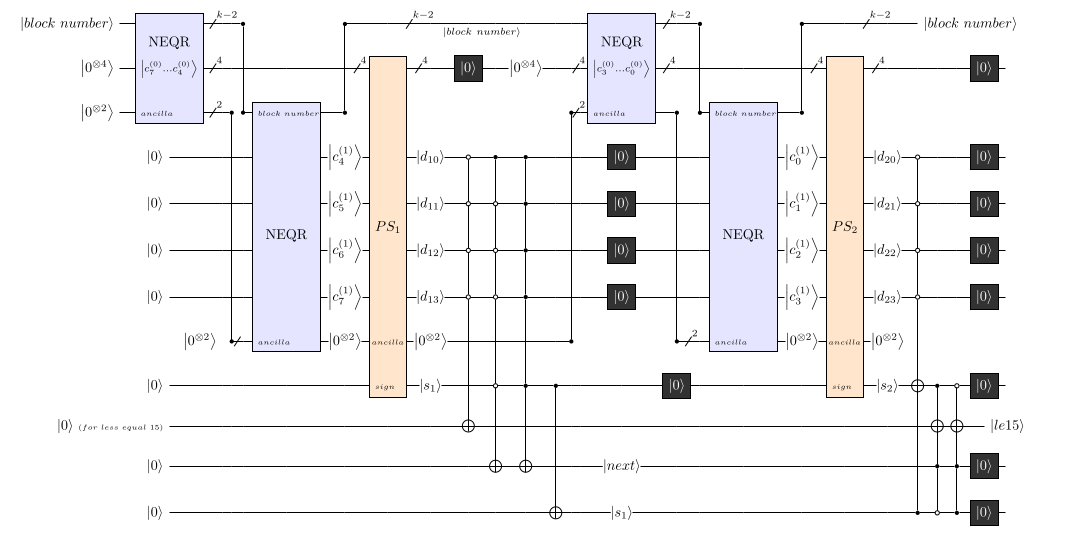

In [46]:
def MLPS(blockNum, color1, color2, sign, ancilla, image_binary_blocks,
                       le15, next_, s1, pixel_num):
    ''' le15 (less equal 15) initial state is zero.
    s1: for saving sign(distance(4 msb))
    pixel_num: pixel number in a block
    
    if distance(4 msb)=0 then le15=1
    if distance(4 msb)>1 then le15=0
    if distance(4 msb)=1 then next=1 then
        if sign(distance(4 msb))=0 and sign(distance(4 lsb))=0 then le15=0
        if sign(distance(4 msb))=0 and sign(distance(4 lsb))=1 then le15=1
        if sign(distance(4 msb))=1 and sign(distance(4 lsb))=1 then le15=0
        if sign(distance(4 msb))=1 and sign(distance(4 lsb))=0 and distance(4 lsb)=0 then le15=0
        if sign(distance(4 msb))=1 and sign(distance(4 lsb))=0 and distance(4 lsb)!=0 then le15=1
        '''
    # 0->[0,0]  1->[1,0]  2->[0,1]  3->[1,1]
    pixel_num_bin = convert_to_binary(pixel_num)[:2]
    
    # ============= neqr pixel 0 part 1 ============ #

    NEQR(coordinate=blockNum,
         color=color1,
         ancilla=ancilla,
         image_binary=image_binary_blocks[:, :, 0, 0, 4:].reshape(-1, 4)) # MSB
    
    # ============= neqr pixel #pixel_num part 1 ============ #

    NEQR(coordinate=blockNum,
         color=color2,
         ancilla=ancilla,
         image_binary=image_binary_blocks[:, :,
                                          pixel_num_bin[1],
                                          pixel_num_bin[0],
                                          4:].reshape(-1, 4)) # MSB
    
    # Y = X-Y  
    parallel_subtractor(X=color1, Y=color2, anc=ancilla, sign=sign)
    
    # if distance(4 msb)=0 then le15=1
    circuit.x(color2)
    mcnot(q_controls=color2, q_target=le15, q_ancilla=ancilla)
    
    # if distance(4 msb)=+1 then next=1 
    circuit.x(color2[0])
    circuit.x(sign)
    q_controls=color2[:]
    q_controls.append(sign)  # q_controls= color2 + sign
    mcnot(q_controls=q_controls, q_target=next_, q_ancilla=ancilla)
    
    # if distance(4 msb)=-1 then next=1 
    circuit.x(color2[1:])
    circuit.x(sign)
    mcnot(q_controls=q_controls, q_target=next_, q_ancilla=ancilla)
    
    # saving sign(distance(4 msb))
    circuit.cnot(sign, s1)
    
    circuit.reset(color1) 
    circuit.reset(color2)
    circuit.reset(sign)
    
    # ============= neqr pixel 0 part 2 ============ #

    NEQR(coordinate=blockNum,
         color=color1,
         ancilla=ancilla,
         image_binary=image_binary_blocks[:, :, 0, 0, :4].reshape(-1, 4)) # LSB
    
    # ============= neqr pixel pixel_num part 2 ============ #

    NEQR(coordinate=blockNum,
         color=color2,
         ancilla=ancilla,
         image_binary=image_binary_blocks[:, :,
                                         pixel_num_bin[1],
                                         pixel_num_bin[0],
                                         :4].reshape(-1, 4)) # LSB  

    parallel_subtractor(X=color1, Y=color2, anc=ancilla, sign=sign)
    
    # if distance(4 msb)=-1 (s1=1) and distance(4 lsb)=0 then
    # change sign(s2) to 1 to not change le15 from zero o one
    circuit.x(color2)
    q_controls=color2[:]
    q_controls.append(s1)
    mcnot(q_controls=q_controls, q_target=sign, q_ancilla=ancilla)
    
    # if distance(4 msb)=+1 and distance(4 lsb)<0 then le15=1
    circuit.x(s1)
    mcnot(q_controls=[sign, next_, s1],
          q_target=le15, q_ancilla=ancilla)
    circuit.x(s1)
    
    # if distance(4 msb)=-1 and distance(4 lsb)>0 then le15=1
    circuit.x(sign)
    mcnot(q_controls=[sign, next_, s1],
          q_target=le15, q_ancilla=ancilla)
    
    circuit.reset(color1)    
    circuit.reset(color2)
    circuit.reset(sign)  
    circuit.reset(s1)  
    circuit.reset(next_)  
    


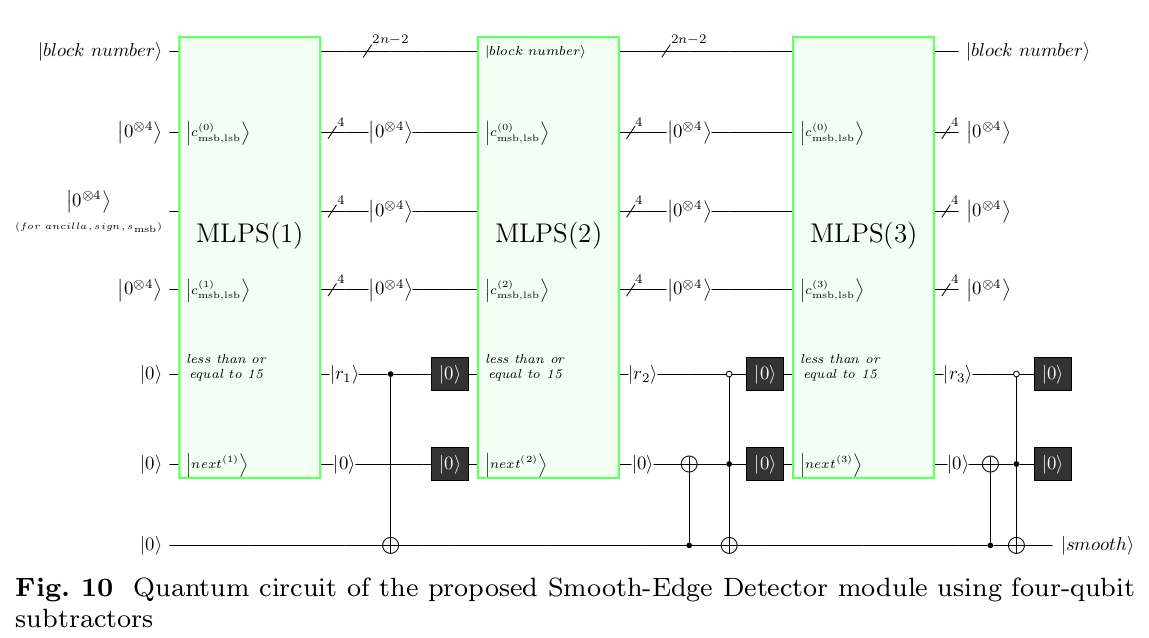

In [8]:
def Smooth_Edge_Detect(blockNum, c0, c123, ancilla, image_binary_blocks, smooth):
    ''' c0:first pixel color, c123:other pixels color
    ancilla[0,1]: MLPS ancilla
    ancilla[2]:sign ,ancilla[3]:s1, ancilla[4]:next_, ancilla[5]:le15
    '''
    MLPS(blockNum,
        color1=c0,
        color2=c123,
        sign=ancilla[2],
        ancilla=ancilla[0:2],
        image_binary_blocks=image_binary_blocks, 
        le15=ancilla[5],
        next_=ancilla[4],
        s1=ancilla[3],
        pixel_num=1)
    
    # cnot(control_qubit=le15, target_qubit=smooth)
    circuit.cnot(control_qubit=ancilla[5], target_qubit=smooth)
    #reset le15
    circuit.reset(ancilla[5])
    
    MLPS(blockNum,
        color1=c0,
        color2=c123,
        sign=ancilla[2],
        ancilla=ancilla[0:2],
        image_binary_blocks=image_binary_blocks, 
        le15=ancilla[5],
        next_=ancilla[4],
        s1=ancilla[3],
        pixel_num=2)

    circuit.cnot(control_qubit=smooth, target_qubit=ancilla[4]) #next_
    circuit.x(ancilla[5]) #le15
    circuit.ccx(control_qubit1=ancilla[5], control_qubit2=ancilla[4], target_qubit=smooth) 
    circuit.reset(ancilla[5])#le15
    circuit.reset(ancilla[4])#next_
    
    MLPS(blockNum,
        color1=c0,
        color2=c123,
        sign=ancilla[2],
        ancilla=ancilla[0:2],
        image_binary_blocks=image_binary_blocks, 
        le15=ancilla[5],
        next_=ancilla[4],
        s1=ancilla[3],
        pixel_num=3)
    
    circuit.cnot(control_qubit=smooth, target_qubit=ancilla[4]) #next_
    circuit.x(ancilla[5]) #le15
    circuit.ccx(control_qubit1=ancilla[5], control_qubit2=ancilla[4], target_qubit=smooth) 
    circuit.reset(ancilla[5])#le15
    circuit.reset(ancilla[4])#next_   
    

In [46]:
def expand(watermark):
    '''Expand and blockize the watermark image
    Make ready and concatenate first row and the second one,
    then concatenate the other first rows and second rows in for loop.
    The bit order of expanded binary watermark is big (4 = 100) unlike the cover image'''
    
    watermark_len = watermark.shape[1] # = watermark.shape[0]
    expandedWatermark_len = 2*watermark_len
    
    W = (
        np.unpackbits(
            watermark.astype(np.uint8),
            axis=1,
            bitorder='big'
                     ).reshape(watermark_len,watermark_len,2, 2, 2)
    )
    W_ = []
    for j in range (watermark_len):
        for y in range (2):
            for i in range (watermark_len):
                for x in range (2):
                    W_.append(W[j][i][y][x])

    return np.array(W_)

Embed
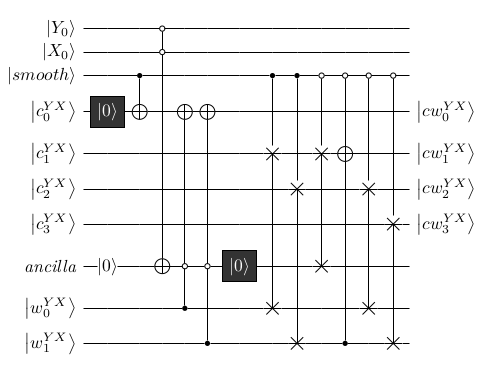

In [ ]:
def embed(r, qcw, qw, anc, y0, x0):
    '''difference: qcw[1] = qw[1] 
    r: qubit indicates edge or smooth 
    qcw: neqr_embedded_watermark_color [0, 3] get neqr_color [0, 3]
    qw: neqr_watermark_color
    anc: 0 , if r=0 then gets c1
    anc[1]: c2
       
    '''
    #for both edge and smooth
    circuit.reset(qcw[0])
    circuit.cnot(control_qubit=r, target_qubit=qcw[0])
    
    #  ================= for pixel 1, 2 and 3, on qubit qcw[0]:
    # ================= if y0=0 x0=0 (pixel0) : anc -> 0 ================= #
    circuit.x(y0)
    circuit.x(x0)  # ccnot with ~x0 and ~y0 control
    circuit.ccx(control_qubit1=y0, control_qubit2=x0, target_qubit=anc)
    circuit.x(y0)
    circuit.x(x0)
    circuit.x(anc)# ccnot with ~anc control
    circuit.ccx(control_qubit1=anc, control_qubit2=qw[0], target_qubit=qcw[0])
    circuit.ccx(control_qubit1=anc, control_qubit2=qw[1], target_qubit=qcw[0])
    circuit.reset(anc)
    # =================================================================== #
    circuit.barrier()
    #  ======================= r=1 : smooth  ============================ #
    circuit.cswap(control_qubit=r, target_qubit1=qcw[1], target_qubit2=qw[0])
    circuit.cswap(control_qubit=r, target_qubit1=qcw[2], target_qubit2=qw[1])
    #  ================================================================== # 
    circuit.barrier()
    circuit.x(r) # ~r control
    circuit.barrier()
    
    # ======================== r=0 : edge   ============================ #
    # ======== change qcw[1]
    # if r=0, then change qcw[1] to 0 and anc to c1
    circuit.cswap(control_qubit=r, target_qubit1=anc, target_qubit2=qcw[1])
    
    circuit.barrier()
    
#     circuit.ccx(control_qubit1=r, control_qubit2=qw[0], target_qubit=qcw[1])
    # qcw[1] = qw[1]
    circuit.ccx(control_qubit1=r, control_qubit2=qw[1], target_qubit=qcw[1])

    circuit.barrier()
    
    # ======== change qcw[2] and qcw[3]      
    # if r=0, then change qcw[2] to c1 and anc to c2
    circuit.cswap(control_qubit=r, target_qubit1=anc, target_qubit2=qcw[2])
    # if r=0, then change qcw[3] to c2 and anc to c3
    circuit.cswap(control_qubit=r, target_qubit1=anc, target_qubit2=qcw[3])
    
    circuit.barrier()
    
    circuit.cswap(control_qubit=r, target_qubit1=qcw[2], target_qubit2=qw[0])
    circuit.cswap(control_qubit=r, target_qubit1=qcw[3], target_qubit2=qw[1])
    #  ================================================================== # 
    
    circuit.barrier()
    circuit.x(r)  # ~r control

# Input

In [4]:
image = np.random.randint(low=0, high=255, size=(16, 16))
# image = np.array([[0, 100],
#                   [200, 255]])
# image = np.array([[0, 14, 128, 255],
#                   [100, 100, 255, 255],
#                   [64, 255, 32, 255],
#                   [255, 255, 255, 255],
#                 ])
# plt.imshow(image, cmap='gray')
# print(image)
# watermark = np.random.randint(low=0, high=255, size=(2, 2))

In [7]:
block8_rows = 2; block8_cols = 2 
image_blocks = (
        image.reshape(
            image.shape[0]//block8_rows, block8_rows, -1, block8_cols
                     ).swapaxes(1,2)
               ).reshape(-1, block8_rows, block8_cols)
image_blocks.shape

(64, 2, 2)

In [24]:
image_binary = np.unpackbits(image.astype(np.uint8),
                                    axis=1, bitorder='little').reshape(image.shape[0]*image.shape[1],
                                                                   8)
# print(image_binary) 

block_rows = 2
block_cols = 2
image_binary_blocks = np.unpackbits(image.astype(np.uint8),            # number of row blocks
                                    axis=1, bitorder='little').reshape(image.shape[0]//block_rows,
                                                                       block_rows,
                                                                       -1,
                                                                       block_cols,
                                                                       8).swapaxes(1,2)
# 

In [ ]:
def expand(watermark):
    '''Expand and blockize the watermark image
    Make ready and concatenate first row and the second one,
    then concatenate the other first rows and second rows in for loop.
    The bit order of expanded binary watermark is big (4 = 100) unlike the cover image'''
    
    watermark_len = watermark.shape[1] # = watermark.shape[0]
    expandedWatermark_len = 2*watermark_len
    
    W = (
        np.unpackbits(
            watermark.astype(np.uint8),
            axis=1,
            bitorder='big'
                     ).reshape(watermark_len,watermark_len,2, 2, 2)
    )
    W_ = []
    for j in range (watermark_len):
        for y in range (2):
            for i in range (watermark_len):
                for x in range (2):
                    W_.append(W[j][i][y][x])

    return np.array(W_)

# Embed and Send

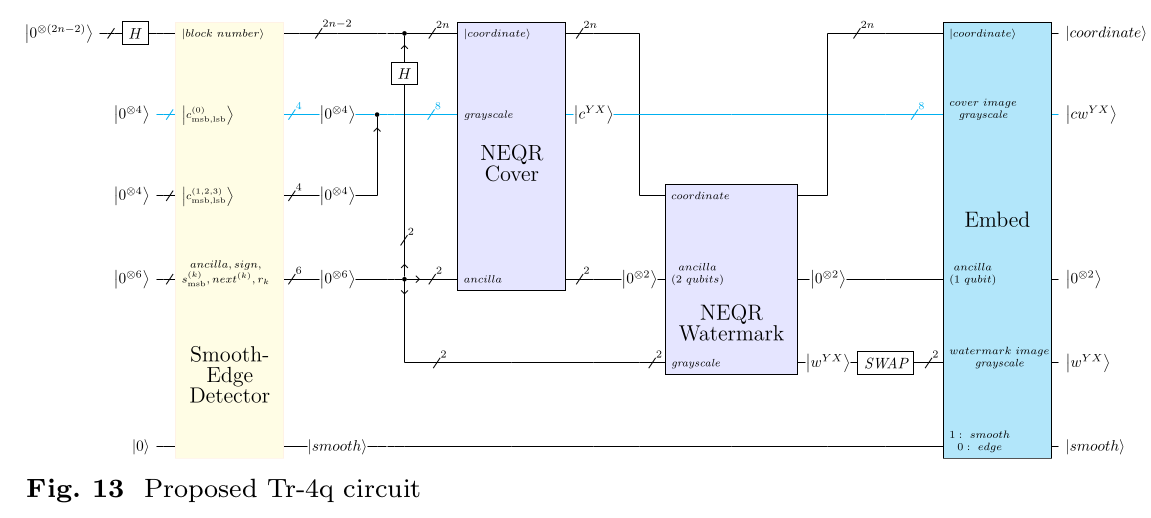

In [22]:
# The input image is devided into 8x8 blocks because of lack of resources

global ccx_count
global xgate_count
global cnot_count


# -------- A 256x256 image is divided to 8x8 blocks  -------- #
block8_rows = 4; block8_cols = 4 
image_blocks = (
        image.reshape(
            image.shape[0]//block8_rows, block8_rows, -1, block8_cols
                     ).swapaxes(1,2)
               ).reshape(-1, block8_rows, block8_cols)

# -------- 128x128 watermark image is blockized to 4x4 blocks  -------- #
block4_rows = block8_rows//2; block4_cols = block8_cols//2 
watermark_blocks = (
        watermark.reshape(
            watermark.shape[0]//block4_rows, block4_rows, -1, block4_cols
                     ).swapaxes(1,2)
               ).reshape(-1, block4_rows, block4_cols)

num_block8_bits = int(np.log2(block8_rows) * 2)  #8-> 3*2

for i in range(len(image_blocks)): # i = 0 to 1023
    ccx_count = 0
    xgate_count = 0
    cnot_count = 0
    # -------- 8x8 integer block is binarized ------ #
    block8_binary = np.unpackbits(
        image_blocks[i].astype(np.uint8), axis=1, bitorder='little'
                                ).reshape(block8_rows*block8_cols,8)
    print('block8_binary:', block8_binary)
    # -------- 8x8 image block is blockized to 2x2 blocks ------ #
    block8_binary_blocks = np.unpackbits(
        image_blocks[i].astype(np.uint8), axis=1, bitorder='little'
    )
    block8_binary_blocks = block8_binary_blocks.reshape(block8_rows//2, 2, -1, 2, 8).swapaxes(1,2)
    
    
    # ----- 4x4 watermark block is expanded to 8x8 block ------ #
    watermark_block8_binary = expand(watermark_blocks[i])
    print('\n\nwatermark_block8_binary:', watermark_block8_binary)
    
    # ---------------------- Circuit ----------------------------------- #
    blockNum = QuantumRegister(num_block8_bits-2, name='blockNum')
    color = QuantumRegister(8, name='color')
    ancilla = QuantumRegister(6, 'ancilla') 
    smooth = QuantumRegister(1, 'smooth') 
    cr = ClassicalRegister(8+1, 'classicalReg')
    circuit = QuantumCircuit(blockNum, color, ancilla, smooth, cr)
    
    quantum_input(1, blockNum)
#     circuit.h(blockNum)
    Smooth_Edge_Detect(blockNum=blockNum,
                        c0=color[:4],
                        c123=color[4:],
                        ancilla=ancilla,
                        image_binary_blocks=block8_binary_blocks,
                        smooth=smooth)

#     circuit.h(ancilla[:2])
    quantum_input(1, ancilla[:2])
    
    coordinate = np.array([ancilla[0]] + 
                  blockNum[:len(blockNum)//2] + 
                  [ancilla[1]] + 
                  blockNum[len(blockNum)//2 : ])

    # cover image NEQR
    NEQR(coordinate=coordinate,
         color=color,
         ancilla=ancilla[2:4],
         image_binary=block8_binary)

    # watermark image NEQR
    NEQR(coordinate=coordinate,
         color=ancilla[4:6],
         ancilla=ancilla[2:4],
         image_binary=np.flip(watermark_block8_binary, axis=1))

#     scramble(neqr_watermark_color=ancilla[4:6])

    embed(r=smooth, 
          qcw=color[:4], 
          qw=ancilla[4:6],
          anc=ancilla[2],
          y0=coordinate[len(coordinate)//2],
          x0=coordinate[0])

    circuit.measure(color, cr[:8])
    circuit.measure(smooth, cr[8:])
    
    
    print('\nnumber of block: ', i)
    print('ccx_count:', ccx_count, '\txgate_count:', xgate_count, 
          '\tcnot_count:', cnot_count)  
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend=simulator, shots=20).result()
    print(result.get_counts(circuit))

block8_binary: [[1 1 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 1 0 0 0]
 [0 0 0 1 1 0 0 0]
 [1 1 1 0 0 0 0 0]
 [1 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [1 0 1 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [1 1 0 0 1 0 0 0]
 [1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]


watermark_block8_binary: [[0 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [0 1]
 [0 0]
 [0 1]]

number of block:  0
ccx_count: 0 	xgate_count: 19 	cnot_count: 48
{'000000101': 20}


In [17]:
image

array([[ 7, 12, 19, 10],
       [22, 24,  7, 11],
       [ 8,  6,  5,  3],
       [15, 19, 17,  0]])